# **I. PROBLEMS UNDERSTANDING**
##1. Context:
- SuperStore is a global retail company offering a diverse range of products. Currently, the Head of the Marketing Team needs the DA team to segment customer groups and provide actionable insights using RFM analysis through Python. These insights will help the MKT Team gain a deeper understanding of their current customers and devise tailored strategies to effectively engage with different customer segments.

##2. Objective:
- Use Python to segment Superstore's customers depend on RFM Model
- Provide insights for the marketing team
- Help MKT and Sales team to evelop effective marketing strategies through this report

## 3. How to solve the problem?
###3.1 EDA
 - Check data info
  - Check missing/duplicate value, outliers, etc
  - Check data type
  - Find the reasons behind and make decision to solve

###3.2 Data Processing
- Feature Engineering for RFM: Calculate the R, F, M scores for each customer.
- Scoring and Segmentation: Assign scores for each R, F, and M metric, respectively, on a 1-5 scale.
- Group customers into segments based on their RFM scores using a standard classification method.

###3.3 Data visualization
- Visualization and Analysis: Customer Segment (treemap)

###3.4 Recommations
- Recommendations and Insights: Suggest specific strategies for each segment.

# II. PRACTICE

In [27]:
# Load thư viện
import numpy as np
import pandas as pd
import os
import warnings
import seaborn as sns
import matplotlib.pyplot as plt

warnings.filterwarnings('ignore')

In [28]:
# Kết nối Drive
from google.colab import drive
drive.mount('/content/drive')

path = '/content/drive/MyDrive/Study/Data_Analyst/3_Python/NgPhuongHuy_RFM_Project/ecommerce_retail.xlsx'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [29]:
# Load dữ liệu file Excel
xls = pd.ExcelFile(path)

# Đọc từng sheet (theo tên hoặc số thứ tự)
ecommerce_retail = xls.parse(sheet_name='ecommerce_retail')
segmentation = xls.parse(sheet_name='Segmentation')

In [30]:
ecommerce_retail.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


## **1. EDA**

**1. Check data type và lọc các dữ liệu chưa phù hợp**


In [31]:
ecommerce_retail.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    541909 non-null  object        
 1   StockCode    541909 non-null  object        
 2   Description  540455 non-null  object        
 3   Quantity     541909 non-null  int64         
 4   InvoiceDate  541909 non-null  datetime64[ns]
 5   UnitPrice    541909 non-null  float64       
 6   CustomerID   406829 non-null  float64       
 7   Country      541909 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 33.1+ MB


In [32]:
ecommerce_retail.describe()

,Quantity,InvoiceDate,UnitPrice,CustomerID
count,541909.000000,541909,541909.000000,406829.000000
mean,9.552250,2011-07-04 13:34:57.156386048,4.611114,15287.690570
min,-80995.000000,2010-12-01 08:26:00,-11062.060000,12346.000000
25%,1.000000,2011-03-28 11:34:00,1.250000,13953.000000
50%,3.000000,2011-07-19 17:17:00,2.080000,15152.000000
75%,10.000000,2011-10-19 11:27:00,4.130000,16791.000000
max,80995.000000,2011-12-09 12:50:00,38970.000000,18287.000000
std,218.081158,NaN,96.759853,1713.600303


In [33]:
print("Duplicates in ecommerce_retail:", ecommerce_retail.duplicated().sum())

Duplicates in ecommerce_retail: 5268


In [34]:
# CustomerID bị null
# Lý do: - Khách chưa đăng nhập, chưa đăng ký
#        - Giao dịch Offline
#        - Người mua không để lại thông tin
# Thiếu khoảng 25%, không thể phân tích được => Loại bỏ
ecommerce_retail = ecommerce_retail.dropna(subset=['CustomerID'])

# Ép CustomerID về kiểu string (để nhìn không bị có dấu .)
ecommerce_retail['CustomerID'] = ecommerce_retail['CustomerID'].astype(int).astype(str)

# Quantity hoặc UnitPrice <= 0
# Lý do: - Huỷ, trả hàng
# Không thể phân tích được => Loại bỏ
ecommerce_retail = ecommerce_retail[(ecommerce_retail['Quantity'] > 0) & (ecommerce_retail['UnitPrice'] > 0)]

# drop duplicates
ecommerce_retail = ecommerce_retail.drop_duplicates()

# Tạo TotalPrice = Quantity * UnitPrice
ecommerce_retail['TotalPrice'] = ecommerce_retail['Quantity'] * ecommerce_retail['UnitPrice']

# Reset index
ecommerce_retail.reset_index(drop=True, inplace=True)

In [35]:
# Gán ngày tham chiếu (ngày phân tích)
import datetime
snapshot_date = datetime.datetime(2011, 12, 31)

## **2. Data Processing**

In [36]:
#Tính RFM metrics
rfm = ecommerce_retail.groupby('CustomerID').agg({
    'InvoiceDate': lambda x: (snapshot_date - x.max()).days,   # Recency
    'InvoiceNo': 'nunique',                                     # Frequency
    'TotalPrice': 'sum'                                         # Monetary
}).reset_index()

rfm.columns = ['CustomerID', 'Recency', 'Frequency', 'Monetary']

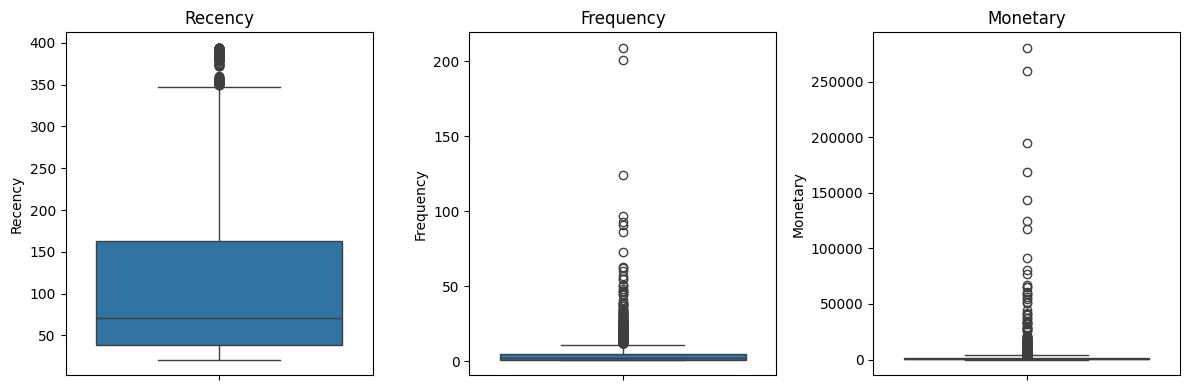

In [37]:
# Vẽ boxplot kiểm tra outlier
plt.figure(figsize=(12,4))
for i, col in enumerate(['Recency', 'Frequency', 'Monetary']):
    plt.subplot(1,3,i+1)
    sns.boxplot(y=rfm[col])
    plt.title(col)
plt.tight_layout()
plt.show()

In [38]:
# Recency: chỉ số phản ánh thực tế => giữ nguyên, không nên loại outlier
# Frequency: loại outlier để giảm ảnh hưởng của reseller
# Monetary: loại outlier để tránh bị bóp méo khi tính điểm
# Xử lý outliers cho Frequency và Monetary
f_max = rfm['Frequency'].quantile(0.95)
m_max = rfm['Monetary'].quantile(0.95)

rfm = rfm[(rfm['Frequency'] <= f_max) & (rfm['Monetary'] <= m_max)]

In [39]:
# Gán điểm R, F, M theo phân vị (1–5)
# Điểm càng cao càng tốt ⇒ Recency ngược
rfm['R_Score'] = pd.qcut(rfm['Recency'], 5, labels=[5,4,3,2,1]).astype(int)
rfm['F_Score'] = pd.qcut(rfm['Frequency'].rank(method='first'), 5, labels=[1,2,3,4,5]).astype(int)
rfm['M_Score'] = pd.qcut(rfm['Monetary'], 5, labels=[1,2,3,4,5]).astype(int)

# Gộp lại thành chuỗi RFM
rfm['RFM_Score'] = rfm['R_Score'].astype(str) + rfm['F_Score'].astype(str) + rfm['M_Score'].astype(str)

In [40]:
# Chuyển cột "RFM Score" từ chuỗi về list:
segment_dict = {}
for _, row in segmentation.iterrows():
    scores = row['RFM Score'].replace(" ", "").split(',')
    for score in scores:
        segment_dict[score] = row['Segment']

In [41]:
#Gán segment cho từng khách hàng
rfm['Segment'] = rfm['RFM_Score'].map(segment_dict)
rfm

,CustomerID,Recency,Frequency,Monetary,R_Score,F_Score,M_Score,RFM_Score,Segment
1,12347,23,7,4310.00,5,5,5,555,Champions
2,12348,96,4,1797.24,3,4,5,345,Loyal
3,12349,39,1,1757.55,4,1,5,415,Promising
4,12350,331,1,334.40,1,1,2,112,Lost customers
5,12352,57,8,2506.04,4,5,5,455,Champions
...,...,...,...,...,...,...,...,...,...
4332,18278,94,1,173.90,3,2,1,321,About To Sleep
4333,18280,298,1,180.60,1,2,1,121,Lost customers
4334,18281,201,1,80.82,2,2,1,221,About To Sleep
4335,18282,28,2,178.05,5,3,1,531,Potential Loyalist


## **3. Data Visualization**

**1. Contribution by Segmentation**

In [42]:
#cài thư viện squarify
!pip install squarify
import squarify
import matplotlib.font_manager as fm

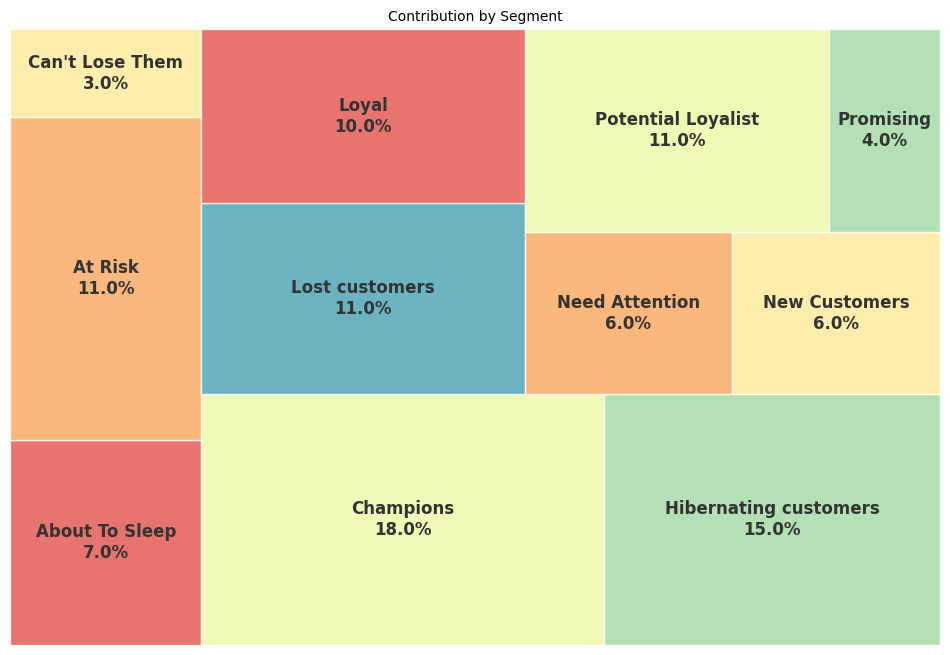

In [43]:
# Count the number of customers in each segment
count_segment_by_users = rfm[['CustomerID', 'Segment']].groupby(['Segment'])['CustomerID'].count().reset_index().rename(columns={'CustomerID': 'Count'})

# Calculate the percentage of each segment
count_segment_by_users['percent_segment_by_users'] = round(count_segment_by_users['Count'] / count_segment_by_users['Count'].sum() * 100)

# Format segment names to include percentage
count_segment_by_users['Segment'] = count_segment_by_users['Segment'] + '\n' + count_segment_by_users['percent_segment_by_users'].astype(str) + '%'

# Plot a treemap to visualize segment contribution
plt.figure(figsize=(12, 8))
squarify.plot(
    sizes=count_segment_by_users['percent_segment_by_users'],
    label=count_segment_by_users['Segment'],
    color=sns.color_palette("Spectral"),
    alpha=0.8,
    text_kwargs={
        'fontsize': 12,
        'color': '#333333',                   # Màu chữ tối
        'weight': 'bold'
    },
    bar_kwargs={'linewidth': 1, 'edgecolor': '#ffffff'}  # Viền trắng cho các ô
)
plt.title("Contribution by Segment", fontsize=10)
plt.axis('off')
plt.show()

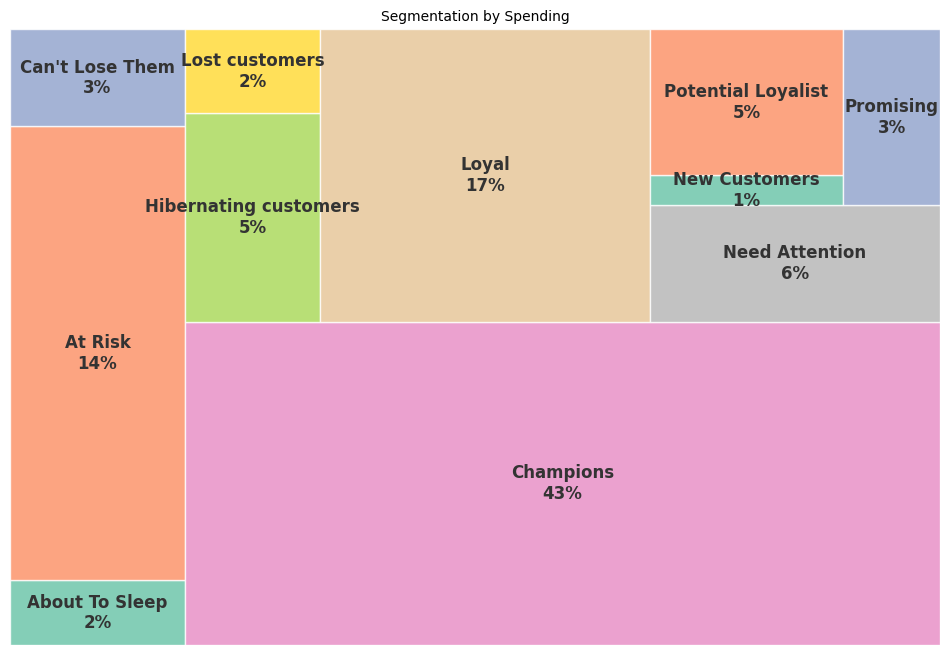

In [44]:
# Aggregate total spending for each segment
segment_by_spending = rfm[rfm.Monetary > 0][['Segment', 'Monetary']].groupby('Segment')['Monetary'].sum().reset_index().rename(columns={'Monetary': 'Spending'})

# Calculate the percentage contribution of each segment to total spending
segment_by_spending['percent_segment_by_spending'] = round(segment_by_spending['Spending'] / segment_by_spending['Spending'].sum() * 100)

# Convert percentage values to integers for better readability
segment_by_spending['percent_segment_by_spending'] = segment_by_spending['percent_segment_by_spending'].astype(int)

# Append percentage values to segment labels
segment_by_spending['Segment'] = segment_by_spending['Segment'] + '\n' + segment_by_spending['percent_segment_by_spending'].astype(str) + '%'

# Remove segments with 0% contribution
segment_by_spending = segment_by_spending[segment_by_spending.percent_segment_by_spending > 0]

# Plot a treemap to visualize spending distribution by segment
plt.figure(figsize=(12, 8))
squarify.plot(
    sizes=segment_by_spending['percent_segment_by_spending'],
    label=segment_by_spending['Segment'],
    color=sns.color_palette("Set2"),
    alpha=0.8,
    text_kwargs={
        'fontsize': 12,
        'color': '#333333',                   # Màu chữ tối
        'weight': 'bold'
    },
    bar_kwargs={'linewidth': 1, 'edgecolor': '#ffffff'}  # Viền trắng cho các ô
)
plt.title("Segmentation by Spending", fontsize=10)
plt.axis('off')
plt.show()

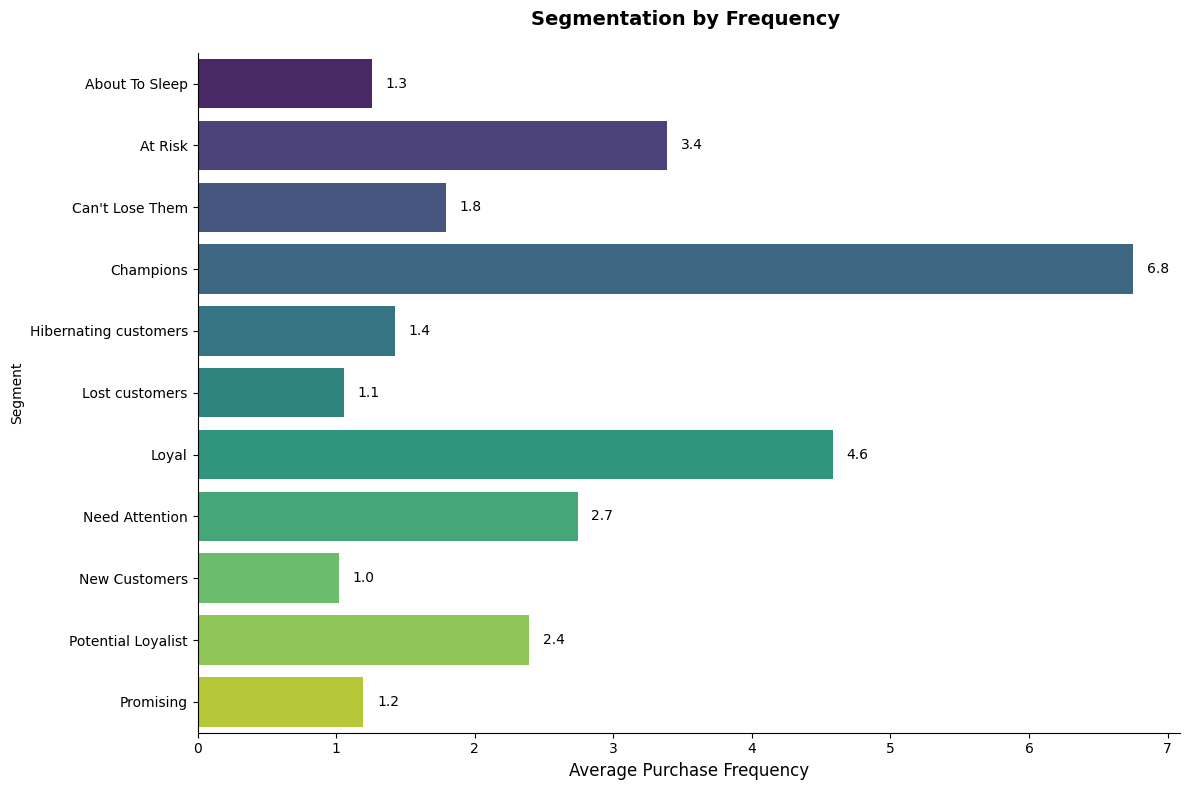

In [45]:
# Tính tần suất mua hàng trung bình theo từng phân khúc
segment_by_frequency = rfm[rfm.Frequency > 0][['Segment', 'Frequency']].groupby('Segment')['Frequency'].mean().reset_index()


# Vẽ biểu đồ cột
plt.figure(figsize=(12, 8))
ax = sns.barplot(data=segment_by_frequency,
                 x='Frequency',
                 y='Segment',
                 palette='viridis',
                 order=segment_by_frequency['Segment'])

# Thêm data label
for p in ax.patches:
    width = p.get_width()
    ax.text(width + 0.1,
            p.get_y() + p.get_height()/2,
            f'{width:.1f}',
            va='center',
            ha='left',
            fontsize=10)

# Thiết lập tiêu đề và nhãn trục
plt.xlabel('Average Purchase Frequency', fontsize=12)
plt.ylabel('Segment')
plt.title('Segmentation by Frequency ',
          fontsize=14,
          pad=20,
          fontweight='bold')

# Tinh chỉnh giao diện
sns.despine()
plt.tight_layout()
plt.show()

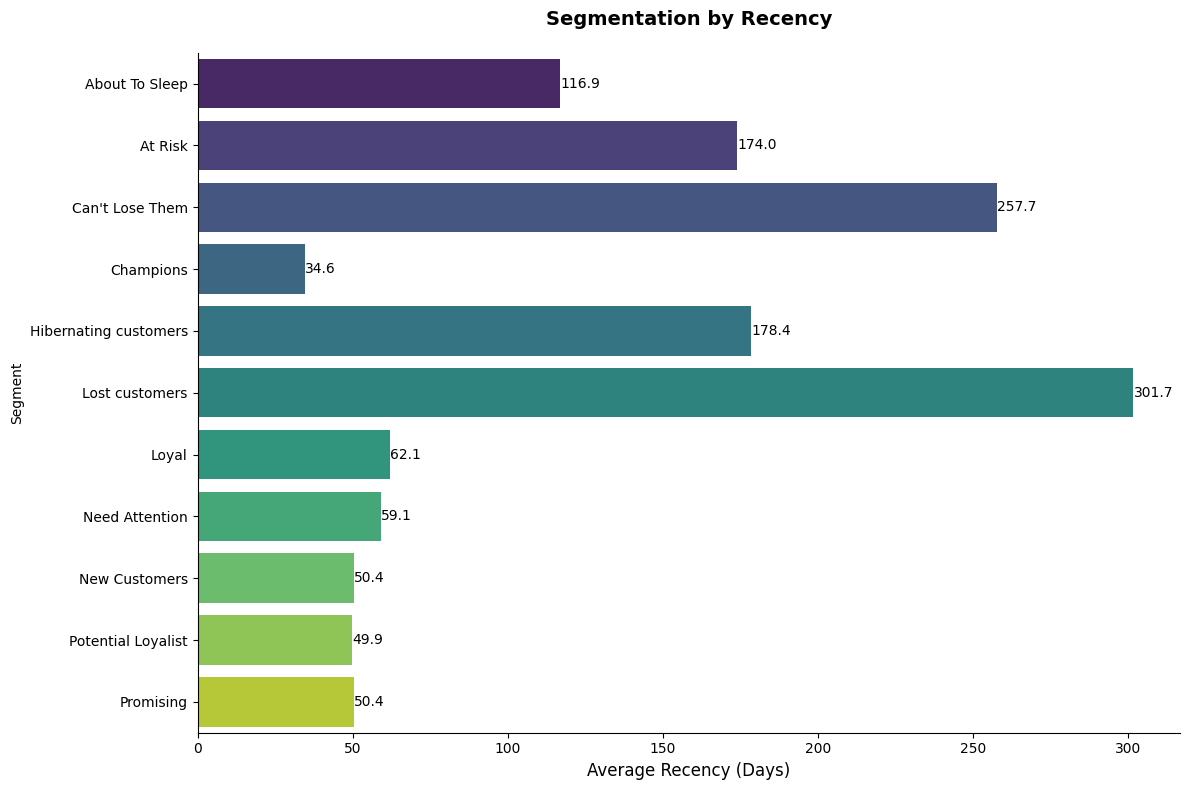

In [46]:
# Tính số ngày mua hàng gần nhất trung bình theo từng phân khúc
segment_by_recency = rfm[rfm.Recency > 0][['Segment', 'Recency']].groupby('Segment')['Recency'].mean().reset_index()

# Vẽ biểu đồ cột
plt.figure(figsize=(12, 8))
ax = sns.barplot(data=segment_by_recency,
                 x='Recency',
                 y='Segment',
                 palette='viridis',
                 order=segment_by_recency['Segment'])

# Thêm data label
for p in ax.patches:
    width = p.get_width()
    ax.text(width + 0.1,
            p.get_y() + p.get_height()/2,
            f'{width:.1f}',
            va='center',
            ha='left',
            fontsize=10)

# Thiết lập tiêu đề và nhãn trục
plt.xlabel('Average Recency (Days)', fontsize=12)
plt.ylabel('Segment')
plt.title('Segmentation by Recency',
          fontsize=14,
          pad=20,
          fontweight='bold')

# Tinh chỉnh giao diện
sns.despine()
plt.tight_layout()
plt.show()


## **4. Recommendation**

